In [ ]:
from openpi.training import config as _config
import jax
import flax.nnx as nnx
from scripts.train import _load_weights_and_validate
from PIL import Image
import jax.numpy as jnp
import openpi.models.tokenizer as _tokenizer
import numpy as np
import openpi.training.data_loader as _data_loader
import openpi.training.sharding as sharding
import lerobot.common.datasets.lerobot_dataset as lerobot_dataset
from openpi.models import model as _model
from openpi.models.pi0_fast import Pi0FAST, make_attn_mask

/scratch/s5649552/conda/envs/openpi/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
config = _config.get_config("pi0_fast_libero")

In [5]:
rng = jax.random.key(42)  # or any seed
model_rng, _ = jax.random.split(rng)

model = config.model.create(model_rng)

params_shape = nnx.state(model).to_pure_dict()

loaded_params = _load_weights_and_validate(config.weight_loader, params_shape)

graphdef, state = nnx.split(model)
state.replace_by_pure_dict(loaded_params)
model = nnx.merge(graphdef, state)

In [ ]:
image = Image.open(f"./ep/11.png").convert("RGB").resize((224, 224))
image = jnp.asarray(image, jnp.float32)
image = (image / 255.0) * 2.0 - 1.0  # Scale to [-1, 1]
image = image[None, ...]  # Add batch dimension
image.shape
prompt = "bip boop"
state = np.array(
    [
        -0.05338004603981972,
        0.007029631175100803,
        0.6783280968666077,
        3.1407692432403564,
        0.0017593271331861615,
        -0.08994418382644653,
        0.03878866136074066,
        -0.03878721222281456,
    ]
)
actions = np.array([0.01607142947614193, 0, 0, 0, 0, 0, -1])
tokenizer = _tokenizer.FASTTokenizer(config.model.max_token_len)
tokens, token_mask, ar_mask, loss_mask = tokenizer.tokenize(prompt, state, actions)
prompt_tokens = jnp.array(tokens)[None, :]  # Add batch dim
prompt_mask = jnp.ones_like(prompt_tokens, dtype=bool)
image_embeddings, _ = model.PaliGemma.img(image, train=False)
text_embeddings = model.PaliGemma.llm(prompt_tokens, embed_only=True)

print("image_embeddings", image_embeddings.shape)
print("text_embeddings", text_embeddings.shape)

(1, 224, 224, 3)

In [37]:
dataset = lerobot_dataset.LeRobotDataset(
    "physical-intelligence/libero",
)

The dataset you requested (physical-intelligence/libero) is in 2.0 format.
While current version of LeRobot is backward-compatible with it, the version of your dataset still uses global
stats instead of per-episode stats. Update your dataset stats to the new format using this command:
```
python lerobot/common/datasets/v21/convert_dataset_v20_to_v21.py --repo-id=physical-intelligence/libero
```

If you encounter a problem, contact LeRobot maintainers on [Discord](https://discord.com/invite/s3KuuzsPFb)
or open an [issue on GitHub](https://github.com/huggingface/lerobot/issues/new/choose).



In [ ]:
ep_num = 0
end_frame = dataset.episode_data_index["to"][ep_num].cpu().item()
image = dataset[end_frame - 1]['image'] # torch.Size([3, 256, 256])
image = np.array(image.permute(1, 2, 0))  # Convert to HWC format
image = (image * 255).astype(np.uint8)
image = Image.fromarray(image).convert("RGB").resize((224, 224))
image = jnp.asarray(image, jnp.float32)
image = (image / 255.0) * 2.0 - 1.0  # Scale to [-1, 1]
image = image[None, ...]  # Add batch dimension
image.shape

(1, 224, 224, 3)

In [31]:
image_embeddings, _ = model.PaliGemma.img(image, train=False)

In [32]:
image_embeddings.shape

(1, 256, 2048)

In [ ]:
pooled_embeddings = []
end_episodes = dataset.episode_data_index["to"].cpu().numpy()
print("End episodes:", end_episodes)
num_frames = len(end_episodes)
print("Num frames:", num_frames)
for i in range(num_frames):
    end_idx = end_episodes[i].item()
    img = dataset[end_idx - 1]['image'] # torch.Size([3, 256, 256])
    img = np.array(img.permute(1, 2, 0))  # Convert to HWC format
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img).convert("RGB").resize((224, 224))
    img = jnp.asarray(img, jnp.float32)
    img = (img / 255.0) * 2.0 - 1.0  # Scale to [-1, 1]
    img = img[None, ...]  # Add batch dimension
    emb, _ = model.PaliGemma.img(img, train=False)
    emb = jnp.squeeze(emb, axis=0)  # [num_patches, embed_dim]
    emb = jnp.mean(emb, axis=0)  # [embed_dim]
    pooled_embeddings.append(emb)

pooled_embeddings = jnp.stack(pooled_embeddings, axis=0)  # [num_frames, embed_dim]
print(pooled_embeddings.shape)
goal_embedding = jnp.mean(pooled_embeddings, axis=0)
print(goal_embedding.shape)

End episodes: [   214    498    843 ... 273216 273356 273465]
Num frames: 1693
(1693, 2048)
(2048,)


In [4]:
goal_embedding = jnp.load("goal_embedding.npy")
kappa = jnp.load("kappa.npy")

In [38]:
len(dataset.episode_data_index["to"]) == len(dataset.episode_data_index["from"])

True

In [21]:
for i in range(493, 844, 20):
    image = dataset[i]["image"]  # torch.Size([3, 256, 256])
    image = np.array(image.permute(1, 2, 0))  # Convert to HWC format
    image = (image * 255).astype(np.uint8)
    image = Image.fromarray(image).convert("RGB").resize((224, 224))
    image = jnp.asarray(image, jnp.float32)
    image = (image / 255.0) * 2.0 - 1.0  # Scale to [-1, 1]
    image = image[None, ...]  # Add batch dimension
    t_embedding, _ = model.PaliGemma.img(image, train=False)
    t_embedding = jnp.squeeze(t_embedding, axis=0)  # [num_patches, t_embeddinged_dim]
    t_embedding = jnp.mean(t_embedding, axis=0)  # [embed_dim]
    reward = -1 / kappa * jnp.sum((t_embedding - goal_embedding) ** 2)
    print(f"{i}: {reward}")

493: -1.76562
513: -1.14062
533: -1.1875
553: -1.07812
573: -1.19531
593: -1.13281
613: -1.09375
633: -1.15625
653: -1.11719
673: -1.07031
693: -1.09375
713: -1.125
733: -1.01562
753: -1.08594
773: -1.22656
793: -1.22656
813: -1.21875
833: -1.17188


In [ ]:
t_embedding, x = model.PaliGemma.img(image, train=False)

In [19]:
print(x.keys())
print(x["logits"].shape)

dict_keys(['stem', 'with_posemb', 'encoder', 'encoded', 'pre_logits_2d', 'pre_logits', 'logits_2d', 'logits'])
(1, 256, 2048)


In [6]:
start_episodes = dataset.episode_data_index["from"].cpu().numpy()
print("Start episodes:", start_episodes)
num_frames = len(start_episodes)
print("Num frames:", num_frames)
distances = []
for i in range(num_frames):
    print(f"Processing frame {i+1}/{num_frames}", end="\r")
    start_idx = start_episodes[i].item()
    img = dataset[start_idx]['image'] # torch.Size([3, 256, 256])
    img = np.array(img.permute(1, 2, 0))  # Convert to HWC format
    img = (img * 255).astype(np.uint8)
    img = Image.fromarray(img).convert("RGB").resize((224, 224))
    img = jnp.asarray(img, jnp.float32)
    img = (img / 255.0) * 2.0 - 1.0  # Scale to [-1, 1]
    img = img[None, ...]  # Add batch dimension
    emb, _ = model.PaliGemma.img(img, train=False)
    emb = jnp.squeeze(emb, axis=0)  # [num_patches, embed_dim]
    emb = jnp.mean(emb, axis=0)  # [embed_dim]
    distances.append(jnp.sum((emb - goal_embedding) ** 2))
kappa = jnp.array(distances)
kappa = jnp.mean(kappa)

Start episodes: [     0    214    498 ... 273083 273216 273356]
Num frames: 1693


In [7]:
jnp.save("kappa.npy", kappa)

In [8]:
kappa

Array(382, dtype=bfloat16)

In [3]:
print("Batch size:", config.batch_size)
data_loader = _data_loader.create_data_loader(
    config,
    shuffle=False,
)
# data_iter = iter(data_loader)
# batch = next(data_iter)

Batch size: 1


Some kwargs in processor config are unused and will not have any effect: time_horizon, action_dim, vocab_size, scale, min_token. 
Some kwargs in processor config are unused and will not have any effect: time_horizon, action_dim, vocab_size, scale, min_token. 
The dataset you requested (physical-intelligence/libero) is in 2.0 format.
While current version of LeRobot is backward-compatible with it, the version of your dataset still uses global
stats instead of per-episode stats. Update your dataset stats to the new format using this command:
```
python lerobot/common/datasets/v21/convert_dataset_v20_to_v21.py --repo-id=physical-intelligence/libero
```

If you encounter a problem, contact LeRobot maintainers on [Discord](https://discord.com/invite/s3KuuzsPFb)
or open an [issue on GitHub](https://github.com/huggingface/lerobot/issues/new/choose).

The dataset you requested (physical-intelligence/libero) is in 2.0 format.
While current version of LeRobot is backward-compatible with it, the 

In [6]:
obs = data_loader._data_loader._data_loader.dataset[213]
obs = jax.tree.map(lambda *x: np.stack(np.asarray(x), axis=0), *obs)
# obs = jax.tree_map(
#     lambda *xs: np.stack([np.asarray(x) for x in xs], axis=0) if np.issubdtype(np.asarray(xs[0]).dtype, np.number) else xs[0],
#     *obs,
# )
# obs = jax.tree_map(
#     lambda x: jax.make_array_from_process_local_data(
#         data_loader._data_loader._sharding, x
#     ),
#     obs,
# )
# obs = _model.Observation.from_dict(obs)
obs

array(['state', 'image', 'image_mask', 'actions', 'tokenized_prompt',
       'tokenized_prompt_mask', 'token_ar_mask', 'token_loss_mask'],
      dtype='<U21')

In [7]:
data_config = config.data.create(config.assets_dirs, config.model)
dataset = _data_loader.create_torch_dataset(data_config, config.model.action_horizon, config.model)
transformed_dataset = _data_loader.transform_dataset(dataset, data_config)

Some kwargs in processor config are unused and will not have any effect: time_horizon, action_dim, vocab_size, scale, min_token. 
Some kwargs in processor config are unused and will not have any effect: time_horizon, action_dim, vocab_size, scale, min_token. 
The dataset you requested (physical-intelligence/libero) is in 2.0 format.
While current version of LeRobot is backward-compatible with it, the version of your dataset still uses global
stats instead of per-episode stats. Update your dataset stats to the new format using this command:
```
python lerobot/common/datasets/v21/convert_dataset_v20_to_v21.py --repo-id=physical-intelligence/libero
```

If you encounter a problem, contact LeRobot maintainers on [Discord](https://discord.com/invite/s3KuuzsPFb)
or open an [issue on GitHub](https://github.com/huggingface/lerobot/issues/new/choose).

The dataset you requested (physical-intelligence/libero) is in 2.0 format.
While current version of LeRobot is backward-compatible with it, the 

In [36]:
dataset.episode_data_index

AttributeError: 'TransformedDataset' object has no attribute 'episode_data_index'

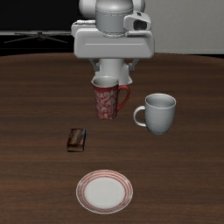

In [ ]:
index = 214
element = transformed_dataset[index]
batched_element = jax.tree.map(lambda x: jnp.expand_dims(jnp.array(x), axis=0), element)
observation = _model.Observation.from_dict(batched_element)
img = observation.images['base_0_rgb'][0]
img = ((img + 1.0) / 2.0 * 255).astype(np.uint8)
img = np.array(img)
Image.fromarray(img)

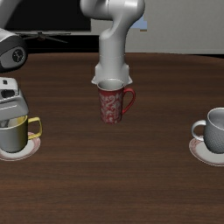

In [40]:
img = data_loader._data_loader._data_loader.dataset[213]['image']['base_0_rgb']
img = Image.fromarray(img)
img

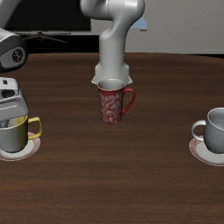

In [41]:
img = dataset[213]['image']
img = np.array(img.permute(1, 2, 0))  # Convert to HWC format
img = (img * 255).astype(np.uint8)
img = Image.fromarray(img).convert("RGB").resize((224, 224))
img

In [33]:
dataset.episode_data_index["to"]

tensor([   214,    498,    843,  ..., 273216, 273356, 273465])

In [8]:
def get_fused_embedding(model: Pi0FAST, observation: _model.Observation):
    """
    Computes a single, fused embedding vector from an observation.

    This function performs the full forward pass to get the context-aware
    latent representation from the PaliGemma model and then pools it into
    a single vector.

    Args:
        model: An instance of your Pi0FAST model.
        observation: The input observation containing images and a prompt.

    Returns:
        A single JAX array representing the fused embedding.
    """
    # 1. Get the concatenated sequence of image and text token embeddings
    # This combines the outputs of the image encoder and the text embedder.
    input_token_embeddings, input_mask, ar_mask = model.embed_inputs(observation)
    
    # 2. Create the attention mask that governs the fusion process
    attn_mask = make_attn_mask(input_mask, ar_mask)
    
    # 3. Pass the full sequence through the LLM to perform fusion
    # We call the LLM to get the final hidden states before the vocabulary projection.
    # This is the 'pre_logits' output from the transformer.
    fused_sequence_embeddings, _, _ = model.PaliGemma.llm(
        embedded_prefix=input_token_embeddings,
        mask=attn_mask,
        return_prelogits=True,
    )
    
    # 4. Pool the fused sequence into a single representative vector
    # We use global average pooling across the sequence length.
    # We apply the input_mask to only average over valid (non-padding) tokens.
    
    # Expand input_mask to be broadcastable with the embeddings
    mask_expanded = jnp.expand_dims(input_mask, axis=-1)
    
    # Sum the embeddings of valid tokens
    summed_embeddings = jnp.sum(fused_sequence_embeddings * mask_expanded, axis=1)
    
    # Count the number of valid tokens
    num_valid_tokens = jnp.sum(input_mask, axis=1, keepdims=True)
    
    # Compute the mean
    pooled_fused_embedding = summed_embeddings / jnp.maximum(num_valid_tokens, 1)
    
    return pooled_fused_embedding

In [9]:
f_embedding = get_fused_embedding(model, batch[0])

In [12]:
batch = next(data_iter)
f_embedding_1 = get_fused_embedding(model, batch[0])

(2048,)


In [17]:
def cosine_similarity(emb1, emb2):
  """Calculates the cosine similarity between two embeddings."""
  dot_product = jnp.dot(emb1, emb2)
  norm_emb1 = jnp.linalg.norm(emb1)
  norm_emb2 = jnp.linalg.norm(emb2)
  return dot_product / (norm_emb1 * norm_emb2)
cosine_similarity(f_embedding, f_embedding_1)

Array(1, dtype=bfloat16)